In [1]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from yahoo_fin import stock_info as si
from collections import deque

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import os
import random

import multiprocessing
    
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)
    
os.environ['TF_ENABLE_AUTO_MIXED_PRECISION'] = '1'

policy = tf.keras.mixed_precision.experimental.Policy('mixed_float16')
tf.keras.mixed_precision.experimental.set_policy(policy) 

In [3]:
def create_model(sequence_length, units=256, cell=LSTM, n_layers=2, dropout=0.3,
                loss="mean_absolute_error", optimizer="rmsprop", bidirectional=False,layer_activation="linear"):
    model = Sequential()
    for i in range(n_layers):
        if i == 0:
            # first layer
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=True), input_shape=(None, sequence_length)))
            else:
                model.add(cell(units, return_sequences=True, input_shape=(None, sequence_length)))
        elif i == n_layers - 1:
            # last layer
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=False)))
            else:
                model.add(cell(units, return_sequences=False))
        else:
            # hidden layers
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=True)))
            else:
                model.add(cell(units, return_sequences=True))
        # add dropout after each layer
        model.add(Dropout(dropout))
    model.add(Dense(1, activation=layer_activation))
    model.compile(loss=loss, metrics=["mean_absolute_error"], optimizer=optimizer)
    return model

In [4]:
#def run_tensorflow():

# create these folders if they does not exist
# Window size or the sequence length
N_STEPS = 72
# Lookup step, 1 is the next day
#LOOKUP_STEP = int(run_dict[run]["LOOKUP_STEP"])

# test ratio size, 0.2 is 20%
TEST_SIZE = 0.3
# features to use
FEATURE_COLUMNS = ["close_0","ema_0","high_0","low_0","open_0","rsi_0","sma_0","volume_0","close_1","ema_1","high_1","low_1","open_1","rsi_1","sma_1","volume_1",
                   "close_2","ema_2","high_2","low_2","open_2","rsi_2","sma_2","volume_2","close_3","ema_3","high_3","low_3","open_3","rsi_3","sma_3","volume_3",
                   "close_4","ema_4","high_4","low_4","open_4","rsi_4","sma_4","volume_4","close_5","ema_5","high_5","low_5","open_5","rsi_5","sma_5","volume_5",
                   "close_6","ema_6","high_6","low_6","open_6","rsi_6","sma_6","volume_6","close_7","ema_7","high_7","low_7","open_7","rsi_7","sma_7","volume_7",
                   "close_8","ema_8","high_8","low_8","open_8","rsi_8","sma_8","volume_8"]
TARGET_COLUMNS = ["close_9","high_9","low_9","open_9"]
# date now
date_now = time.strftime("%Y-%m-%d")

### model parameters

N_LAYERS = 4
# LSTM cell
CELL = LSTM
# 256 LSTM neurons
UNITS = 40
# 40% dropout
DROPOUT = 0.25
# whether to use bidirectional RNNs
BIDIRECTIONAL = True

### training parameters

# mean absolute error loss
# LOSS = "mae"
# huber loss
LOSS = "huber_loss"
OPTIMIZER = "adam"
BATCH_SIZE = 64
EPOCHS = 30

LAYER_ACTIVATION = "linear"

# Stock market
ticker = "MIXED"
ticker_data_filename = os.path.join("data", f"{ticker}_{date_now}.csv")
# model name to save, making it as unique as possible based on parameters
model_name = f"{date_now}_{ticker}-{LOSS}-{OPTIMIZER}-{CELL.__name__}-{LAYER_ACTIVATION}-layers-{N_LAYERS}-units-{UNITS}"
if BIDIRECTIONAL:
    model_name += "-b"

#----------------------------------------------------------------------------------------------------------#
#----------------------------------------------------------------------------------------------------------#
#----------------------------------------------------------------------------------------------------------#

#try:
if not os.path.isdir("results"):
    os.mkdir("results")

if not os.path.isdir("logs"):
    os.mkdir("logs")

if not os.path.isdir("data"):
    os.mkdir("data")

# load the data
data = pd.read_csv('../data/processed/all_processed_10.csv')

# construct the model
model = create_model(N_STEPS, loss=LOSS, units=UNITS, cell=CELL, n_layers=N_LAYERS,
                    dropout=DROPOUT, optimizer=OPTIMIZER, bidirectional=BIDIRECTIONAL, layer_activation=LAYER_ACTIVATION)

# some tensorflow callbacks
checkpointer = ModelCheckpoint(os.path.join("results", model_name + ".h5"), save_weights_only=True, save_best_only=True, verbose=1)
tensorboard = TensorBoard(log_dir=os.path.join("logs", model_name))

X = data[FEATURE_COLUMNS]
y = data[TARGET_COLUMNS]

# convert to numpy arrays
X = np.array(X)
y = np.array(y)

# reshape X to fit the neural network
X = X.reshape((X.shape[0], 1, X.shape[1]))

# split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, shuffle=True)

history = model.fit(X_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(X_test, y_test),
                    callbacks=[checkpointer, tensorboard],
                    verbose=1)

model.save(os.path.join("results", model_name) + ".h5")

#except:
#    print("There was an attempt.")
tf.keras.backend.clear_session()

Train on 67485 samples, validate on 28923 samples
Epoch 1/30
67392/67485 [============================>.] - ETA: 0s - loss: 0.5286 - mean_absolute_error: 0.9016
Epoch 00001: val_loss improved from inf to 0.51582, saving model to results\2021-11-30_MIXED-huber_loss-adam-LSTM-linear-layers-4-units-40-b.h5
67485/67485 [==============================] - 33s 490us/sample - loss: 0.5285 - mean_absolute_error: 0.9015 - val_loss: 0.5158 - val_mean_absolute_error: 0.8861
Epoch 2/30
67392/67485 [============================>.] - ETA: 0s - loss: 0.5151 - mean_absolute_error: 0.8856
Epoch 00002: val_loss improved from 0.51582 to 0.51310, saving model to results\2021-11-30_MIXED-huber_loss-adam-LSTM-linear-layers-4-units-40-b.h5
67485/67485 [==============================] - 22s 329us/sample - loss: 0.5150 - mean_absolute_error: 0.8856 - val_loss: 0.5131 - val_mean_absolute_error: 0.8827
Epoch 3/30
67392/67485 [============================>.] - ETA: 0s - loss: 0.5104 - mean_absolute_error: 0.8800
E

dict_keys(['loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error'])


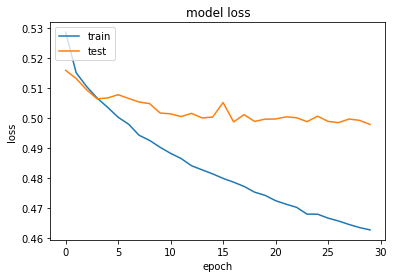

In [5]:
# list all data in history
print(history.history.keys())

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()